In [3]:
import time
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from pybounds import Simulator, SlidingEmpiricalObservabilityMatrix, FisherObservability, SlidingFisherObservability, ObservabilityMatrixImage, colorline

# Define system dynamics and measurements
This example uses a model of an insect flying in the presence of wind.

See the following reference for details:

Floris van Breugel
A Nonlinear Observability Analysis of Ambient Wind Estimation with Uncalibrated Sensors, Inspired by Insect Neural Encoding
2021 60th IEEE Conference on Decision and Control (CDC)
DOI: 10.1109/CDC45484.2021.9683219

The system dynamics are described by seven primary states:
* altitude $z$
* parallel velocity $v_{\parallel}$
* perpendicular velocity $v_{\perp}$
* heading $\phi$
* angular velocity $\dot{\phi}$
* wind speed $w$
* wind direction $\zeta$

And the system dynamics are given by
$$
\dot{\mathbf{x}} = \begin{bmatrix} \dot{z} \\ \dot{v}_{\parallel} \\ \dot{v}_{\perp} \\ \dot{\phi} \\ \ddot{\phi} \\ \dot{w}  \\ \dot{\zeta} \end{bmatrix} = 
f(\mathbf{x}) = \begin{bmatrix} 
\dot{z} \\
\frac{1}{m}(k_{m_1}u_{\parallel} - C_{\parallel} a_{\parallel}) + v_{\perp} \dot{\phi} \\
 \frac{1}{m}(k_{m_3}u_{\perp} - C_{\perp} a_{\perp}) - v_{\parallel} \dot{\phi} \\
  \dot{\phi} \\
   \frac{1}{I}(k_{m_4}u_{\phi} - C_{\phi} \dot{\phi} + k_{m_2} u_{\perp}) \\
    \dot{w} \\
     \dot{\zeta} \\
\end{bmatrix}
$$

where the air velocity is given by

$$
\begin{bmatrix} a_{\parallel} \\ a_{\perp} \end{bmatrix} =  \begin{bmatrix} v_{\parallel} - w \cos(\phi - \zeta) \\ v_{\perp} + w \sin(\phi - \zeta) \end{bmatrix}
$$
The inputs $u_{\bullet}$ are
* parallel thrust force $u_{\parallel}$
* perpendicular thrust force $u_{\perp}$
* turning torque $u_{\phi}$

The inertia parameters (mass $m$ and inertia $I$), damping terms $C_{\bullet}$, and motor calibration coefficients $k_{m_{\bullet}}$ can also be considered states. Other auxiliary states, like the $x$ and $y$ position can also be added.

The putative system measurements are:
* heading $\phi$
* ground speed angle $\psi$
* apparent airflow angle $\gamma$
* apparent airflow magnitude $a$
* ground speed magnitude $g$
* optic flow $g/z$

Where the measurement function is given by:

$$
\mathbf{y} = h(\mathbf{x}) = \begin{bmatrix} \phi \\ \psi \\ \gamma  \\ a \\ g \\ r \end{bmatrix} = 
\begin{bmatrix} \phi \\
\arctan(v_{\perp}/ v_{\parallel}) \\
\arctan(a_{\perp} / a_{\parallel}) \\
\sqrt{a_{\parallel}^2 + a_{\perp}^2} \\
\sqrt{v_{\parallel}^2 + v_{\perp}^2} \\
\sqrt{v_{\parallel}^2 + v_{\perp}^2} / z \\
\end{bmatrix}
$$



## Define dynamics function
The dynamics function takes in a list of states $X$ and a list of inputs $U$ and outputs the derivative of the states.

The optional state & input names must be in the same order as the states & inputs in $X$ & $U$.

In [5]:
# an example of how actions are resolved
# # head_direction_t0 = head_direction[0] # norm'd by pi
# head_direction_t1 = head_direction[1] # norm'd by pi
# agent_angle_complex_vec_t0 = episode_log['infos'][0][0]['angle']
# agent_angle_complex_vec_t1 = episode_log['infos'][1][0]['angle']
# print(f"agent_angle_t0: {agent_angle_complex_vec_t0}")
# print(f"agent_angle_t1: {agent_angle_complex_vec_t1}")

# agent_angle_rad_t0 = np.angle(agent_angle_complex_vec_t0[0] + 1j*agent_angle_complex_vec_t0[1], deg=False) # not norm'd by pi 0.30103736300307615
# agent_angle_rad_t1 = np.angle(agent_angle_complex_vec_t1[0] + 1j*agent_angle_complex_vec_t1[1], deg=False) # not norm'd by pi 0.6844864019832495
# print(f"t0 angle rad = {agent_angle_rad_t0}")
# print(f"t1 angle rad = {agent_angle_rad_t1}")


# action_t0 = episode_log['actions'][0]
# action_t1 = episode_log['actions'][1]
# action_t0_sq = np.clip((np.tanh(action_t0) + 1)/2, 0.0, 1.0) # squash action
# action_t1_sq = np.clip((np.tanh(action_t1) + 1)/2, 0.0, 1.0) # squash action
# turn_action_t0 = action_t0_sq[1]
# turn_action_t1 = action_t1_sq[1]
# # turn_action = 1 - turn_action # invert turn action
# # print(f"turn_action: {turn_action}")
# # # print(f"action_t0_sq: {action_t0_sq}")
# turn_capacity = 6.25*np.pi
# turnx = 1
# dt = env_dt = 0.04
# # print(f"turn by {turn_capacity*turnx*(turn_action_t1 - 0.5)*dt} rad")
# my_agent_angle_rad_t1 = agent_angle_rad_t0 + turn_capacity*turnx*(turn_action_t1 - 0.5)*dt # in radians; (Turn~[0, 1], with 0.5 = no turn, <0.5 turn cw, >0.5 turn ccw)
# print(f"sim new angle rad = {my_agent_angle_rad_t1}")




In [7]:
state_names = [
               'v_para',  # parallel ground velocity [m/s]
               'v_perp',  # perpendicular ground velocity [m/s]
               'phi', # heading [rad]
               'w',  # ambient wind speed [m/s]
               'zeta',  # ambient wind angle [rad]
               ]

input_names = ['u_para',  # translational speed [m/s]
               'u_phi',  # angular velocity [rad/s]
               'u_para_dot'  # translational acceleration [m/s^2] 
                ]

def f(X, U):
    '''
    Return Xdot given X and U
    
    X: state vector
        v_para: ground velocity in the direction parallel to head direction (egocentric frame) [m/s]
        v_perp: ground velocity perpendicular to head direction (egocentric frame) [m/s]
        phi: heading [rad]
        w: wind speed [m/s]
        zeta: wind angle [rad]
    U: input vector assuming actions have been squashed and scaled
        u_para: translational speed [m/s]
        u_phi: angular velocity [rad/s]
        u_para_dot: translational acceleration [m/s^2]
    '''
    # States
    v_para, v_perp, phi, w, zeta = X
    
    # Inputs
    u_para, u_phi, u_para_dot = U # keep u_para because it is in the observation matrix
    # Scale actions by fly capabilities TODO preprocess trajectory data by squash and scale; see /src/JH_boilerplate/dev_test/env/explore_pkl.ipynb
    # u_para = u_para * 2.0 # Max agent speed in m/s
    # u_para_dot = u_para_dot * 2.0 # Max agent acceleration in m/s^2
    # u_phi = u_phi * 6.25*np.pi # Max agent CW/CCW turn per second
    
    # Dynamics
    w_dot = 0*w # wind speed is constant
    zeta_dot = 0*w # wind angle is constant NOTE: may be time varying
    phi_dot = u_phi # angular velocity is controlled by agent
    v_perp_dot = -w * np.cos(phi - zeta) * u_phi + w * np.cos(phi - zeta) * zeta_dot - w_dot * np.sin(phi - zeta) 
    v_para_dot = -w * np.sin(phi - zeta) * u_phi + w * np.cos(phi - zeta) * zeta_dot + w_dot * np.cos(phi - zeta) + u_para_dot

    # Other dynamics
    # x_dot = v_para * np.cos(phi) - v_perp * np.sin(phi)
    # y_dot = v_para * np.sin(phi) + v_perp * np.cos(phi)

    # Package and return xdot
    X_dot = [v_para_dot, v_perp_dot, phi_dot, w_dot, zeta_dot]

    return X_dot

## Define measurement function
The measurement function takes in a list of states $X$ and a list of inputs $U$ and outputs the measurements $Y$.

The optional measurement names must be in the same order as the measurements in $Y$.

In [8]:
measurement_names = ['phi', 'A_para', 'psi'] # heading, apparent wind parallel component, drift angle/egocentric course angle
def h(X, U):
    '''
    Measurement functions - input is the state and control input; output is the measurement
    Assuming control signals are squashed and scaled
    '''
    # States
    v_para, v_perp, phi, w, zeta = X
    
    # Inputs
    u_para, u_phi, u_para_dot = U
    
    # Measurements
    # Heading
    phi = phi # heading is directly observable 
    # Apparent wind
    A_para = - u_para # equal and opposite to translational speed which is in line with head direction and thus have only a parallel component
    # Course direction in fly reference frame
    psi = np.arctan2(v_perp, v_para) # drift angle / egocentric course angle  # TODO numerically check if this is actually the drift angle - yes according to Ben
    
    # Unwrap angles TODO what is this?
    if np.array(phi).ndim > 0:
        if np.array(phi).shape[0] > 1:
            phi = np.unwrap(phi)
            psi = np.unwrap(psi)
            # gamma = np.unwrap(gamma)

    # Measurements
    Y  = [phi, A_para, psi]

    # Return measurement
    return Y


## Set time-step

In [9]:
dt = 0.04  # [s]

# Create simulator object

In [13]:
simulator = Simulator(f, h, dt=dt, state_names=state_names, input_names=input_names, measurement_names=measurement_names)

# Can also set the number of state (n) & inputs (m0 instead of state & input names)
# simulator = Simulator(f, h, dt=dt, n=len(state_names), m=len(input_names))

# Load inference-time trajectories 

In [19]:
log_fname = '/src/data/wind_sensing/apparent_wind_visual_feedback/sw_dist_logstep_wind_0.001_debug_yes_vec_norm_train_actor_std/eval/plume_14421_37e2cd4be4c96943d0341849b40f81eb/constantx5b5.pkl'
# load pkl file
import pickle
import numpy as np
with open(log_fname, 'rb') as f_handle:
    episode_logs = pickle.load(f_handle)
print('Loaded episode logs from', log_fname)
print('Number of episodes:', len(episode_logs))
print('Episodes contain:', episode_logs[0].keys())
print('For more info on pkl content see /src/JH_boilerplate/dev_test/env/explore_pkl.ipynb')

Loaded episode logs from /src/data/wind_sensing/apparent_wind_visual_feedback/sw_dist_logstep_wind_0.001_debug_yes_vec_norm_train_actor_std/eval/plume_14421_37e2cd4be4c96943d0341849b40f81eb/constantx5b5.pkl
Number of episodes: 240
Episodes contain: dict_keys(['trajectory', 'observations', 'actions', 'rewards', 'infos', 'activity'])
For more info on pkl content see /src/JH_boilerplate/dev_test/env/explore_pkl.ipynb


In [31]:
type(episode_logs[0]['actions'])

list

In [34]:
# episode_logs[0]['trajectory'] # x, y locations 
# episode_logs[0]['observations'] # 
# episode_logs[0]['actions'] # needs to be squashed 
# episode_logs[0]['infos'][0][0].keys() # needs to be squashed 
raw_actions = episode_logs[0]['actions']
# TODO: function that squashes and scales actions. output is u_sim a dict with keys 'u_para', 'u_phi', 'u_para_dot', and values are np arrays
# stack a list of actions into a 2D array
raw_actions = np.stack(raw_actions)

def squash_and_scale_actions(raw_actions, dt):
  '''
  Logged actions are the raw outputs of the agent. They need to be translated into the control inputs for the simulator.
  1. Squash the actions to [0, 1]
  2. Scale the actions to the fly's capabilities
  3. Calculate the translational acceleration - new need to be checked
  4. Return a dictionary of control inputs for the simulator
  '''
  def squash_action(x):
    return np.clip((np.tanh(x) + 1)/2, 0.0, 1.0) # squash action, center and scale to [0, 1], per action treatment 

  if type(raw_actions) is list:
    raw_actions = np.stack(raw_actions)
    
  # Vectorize the function # TODO sanity check
  vsquash_action = np.vectorize(squash_action)

  # Apply the vectorized function to the array
  actions = vsquash_action(raw_actions)

  # Scale actions by fly capabilities 
  actions[:, 0] = actions[:, 0] * 2.0 # Max agent speed in m/s
  actions[:, 1] = actions[:, 1] * 6.25*np.pi # Max agent CW/CCW turn per second

  # Calculate translational acceleration
  acc = np.diff(actions[:, 0]) / dt # TODO check this - new operation 
  acc = np.insert(acc, 0, 0) # first acceleration is 0
  
  # Put into a dict
  u_sim = {'u_para': actions[:, 0], 'u_phi': actions[:, 1], 'u_para_dot': acc}
  
  return u_sim

u_sim = squash_and_scale_actions(raw_actions, dt)

# Re-run simulator with MPC inputs
This step isn't required, but it shows how the closed-loop MOC inputs can be replayed in open-loop to get the same state trajectory

In [35]:
t_sim, x_sim, u_sim, y_sim = simulator.simulate(x0=None, mpc=False, u=u_sim, return_full_output=True)

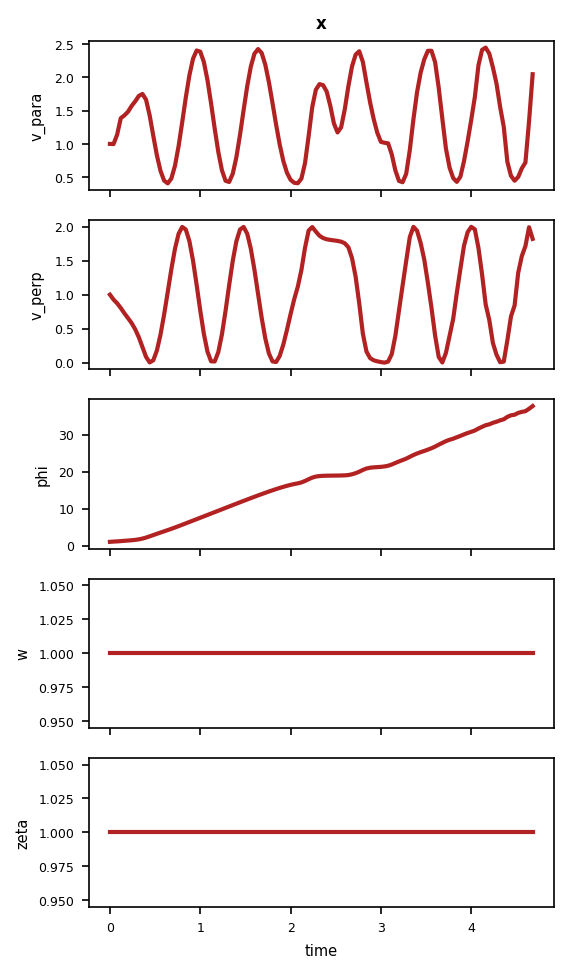

In [36]:
# Plot state
simulator.plot('x')

# Observability

## Construct observability matrix in sliding windows

In [15]:
w = 4  # window size, set to None to use entire time-series as one window

In [ ]:
# Construct O in sliding windows
st = time.time()
SEOM = SlidingEmpiricalObservabilityMatrix(simulator, t_sim, x_sim, u_sim, w=w, eps=1e-4)
et = time.time()
print('elapsed time:', et-st)

In [17]:
# Get O's
O_sliding = SEOM.get_observability_matrix()

In [ ]:
n_window = len(O_sliding)
print(n_window, 'windows')

In [ ]:
# Visualize first sliding observability matrix, this will throw errors if O is too big
OI = ObservabilityMatrixImage(O_sliding[0], cmap='bwr')
OI.plot(scale=1.0)

## Compute Fisher information matrix & inverse for first window


In [20]:
# Set each sensor noise level
sensor_noise = {'phi': 0.1, 'psi': 0.1, 'gamma': 0.1, 'a': 0.1, 'g': 0.1, 'r': 0.1}

In [21]:
# Compute the Fisher information & Chernoff inverse
FO = FisherObservability(SEOM.O_df_sliding[0], R=None, sensor_noise_dict=sensor_noise, lam=1e-6)

# Can also set R directly as matrix or as scalar
# FO = FisherObservability(SEOM.O_df_sliding[0], R=0.1*np.eye(O_sliding[0].shape[0]), lam=1e-6)
# FO = FisherObservability(SEOM.O_df_sliding[0], R=0.1, lam=1e-6)

In [ ]:
# Get the Fisher information, inverse, and R matrix
F, F_inv, R = FO.get_fisher_information()
F_inv

## Compute Fisher information matrix & inverse for each sliding window

In [23]:
# Choose sensors to use from O
o_sensors = ['phi', 'psi', 'gamma']

# Chose states to use from O
o_states = ['v_para', 'v_perp', 'phi', 'phi_dot', 'w', 'zeta', 'z', 'm', 'I', 'C_para', 'C_perp', 'C_phi']

# Choose time-steps to use from O
window_size = 4
o_time_steps = np.arange(0, window_size, step=1)

In [24]:
# Compute the Fisher information & inverse for each window and store the minimum error variance
SFO = SlidingFisherObservability(SEOM.O_df_sliding, time=SEOM.t_sim, lam=1e-6, R=None, sensor_noise_dict=sensor_noise,
                                 states=o_states, sensors=o_sensors, time_steps=o_time_steps, w=None)

In [25]:
# Pull out minimum error variance, 'time' column is the time vector shifted forward by w/2 and 'time_initial' is the original time
EV_aligned = SFO.get_minimum_error_variance()

In [ ]:
EV_aligned

In [ ]:
# Visualize observability matrix subset
OI = ObservabilityMatrixImage(SFO.FO[-1].O)
OI.plot()

# Plot error variance as color on state time-series

In [ ]:
EV_no_nan = EV_aligned.fillna(method='bfill').fillna(method='ffill')

In [ ]:
states = list(SFO.FO[0].O.columns)
n_state = len(states)

fig, ax = plt.subplots(n_state, 2, figsize=(6, n_state*2), dpi=150)
ax = np.atleast_2d(ax)

cmap = 'inferno_r'

min_ev = np.min(EV_no_nan.iloc[:, 2:].values)
max_ev = np.max(EV_no_nan.iloc[:, 2:].values)

log_tick_high = int(np.ceil(np.log10(max_ev)))
log_tick_low = int(np.floor(np.log10(min_ev)))
cnorm = mpl.colors.LogNorm(10**log_tick_low, 10**log_tick_high)

for n, state_name in enumerate(states):
    # colorline(t_sim, x_sim[state_name], EV_no_nan[state_name].values, ax=ax[n, 0], cmap=cmap, norm=cnorm)
    colorline(x_sim['x'], x_sim['y'], EV_no_nan[state_name].values, ax=ax[n, 0], cmap=cmap, norm=cnorm)
    colorline(t_sim, EV_no_nan[state_name].values, EV_no_nan[state_name].values, ax=ax[n, 1], cmap=cmap, norm=cnorm)

    # Colorbar
    cax = ax[n, -1].inset_axes([1.03, 0.0, 0.04, 1.0])
    cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=cnorm, cmap=cmap), cax=cax,
                        ticks=np.logspace(log_tick_low, log_tick_high, log_tick_high-log_tick_low + 1))
    cbar.set_label('min. EV: ' + state_name, rotation=270, fontsize=7, labelpad=8)
    cbar.ax.tick_params(labelsize=6)
    
    ax[n, 0].set_ylim(np.min(x_sim['y']) - 0.01, np.max(x_sim['y']) + 0.01)
    ax[n, 0].set_xlim(np.min(x_sim['x']) - 0.01, np.max(x_sim['x']) + 0.01)
    ax[n, 0].set_ylabel('y', fontsize=7)
    ax[n, 0].set_xlabel('x', fontsize=7)
    ax[n, 0].set_aspect(1.0)

    ax[n, 1].set_ylim(10**log_tick_low, 10**log_tick_high)
    ax[n, 1].set_yscale('log')
    ax[n, 1].set_ylabel('min. EV: ' + state_name, fontsize=7)
    ax[n, 1].set_yticks(np.logspace(log_tick_low, log_tick_high, log_tick_high-log_tick_low + 1))


for a in ax.flat:
    a.tick_params(axis='both', labelsize=6)
    
for a in ax[:, 1]:
    a.set_xlabel('time (s)', fontsize=7)
    a.set_xlim(-0.1, t_sim[-1] + 0.1)
    
# for a in ax[:, 1]:
#     a.set_xlim(-0.1, t_sim[-1] + 0.1)

fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.4)

plt.show()